In [1]:
from tqdm import tqdm
from copy import copy
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
font = {'family' : 'Helvetica',
        'size'   : 7}
mpl.rc('font', **font)
from matplotlib import cm
viridis = cm.get_cmap("viridis", 100)

import numpy as np
import cotengra as ctg

from src.circuit import get_random_circuit

/var/folders/04/n445qjrd23s722yrr6_ddmpm0000gp/T/ipykernel_38406/494177622.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap("viridis", 100)


# Analytical PDF

In [2]:
def pdf_top(N, k, t):
    return 2**k * (1-np.exp(-N*t))**(2**k - 1) * N * np.exp(-N*t)

def pdf_q(N, t):
    return N**2 * t * np.exp(-N * t)

def pdf_u(N, t):
    return N * np.exp(-N*t)

def pdf(N, k, phi, t):
    return np.cumsum((1 - np.exp(-N * t / phi))**(2**k - 1) * np.exp(- N * t / phi + N * t / (1 - phi))) * (t[1] - t[0]) * N**2 * np.exp(-N * t / (1 - phi)) * 2**k / phi / (1 - phi)

def R(phi, y1, x2, x3):
    return (y1 - phi * x2 - (1 - phi) * x3) / (2 * np.sqrt(phi * (1 - phi) * x2 * x3))

def f_R(R):
    result = 1 / np.pi / np.sqrt(1 - R ** 2)
    result[np.where(R**2 > 1)] = 0
    return result

# Evidence for the theory of frugal rejection sampling probability distribution.

## Generate random circuit

In [3]:
N = 20
d = 8
quimb_circuit = get_random_circuit(N, d)

## Defining tensor network contraction optimizer

In [10]:
max_repeats = 100
max_time = 20
minimize_target = 'flops'
nslices = 1024

hyperparameters = {
                "methods": ['greedy', 'kahypar'],
                "max_repeats": max_repeats,
                "max_time": max_time,
                "minimize": minimize_target,
                "parallel": 12,
                "progbar": True,
                "slicing_opts": {
                    "allow_outer": False,
                    "target_slices": nslices,
                },
                "optlib": "random",
            }

## Defining tensor network
### The tensor network is for the output state vector.

In [11]:
psi_b = quimb_circuit.get_psi_simplified()
eq = psi_b.get_equation()
operands = []
for tensor in psi_b.tensors:
    operands.append(np.array(tensor.data, dtype = np.complex128))

## Sliced contraction tree

In [12]:
opt = ctg.HyperOptimizer(**hyperparameters)
output_inds = ([psi_b.site_ind(i) for i in range(N)])
tree = psi_b.contraction_tree(output_inds=output_inds, optimize=opt)

F=9.40 C=10.91 S=20.00 P=20.09 $=1024.00: 100%|██████████| 100/100 [00:02<00:00, 38.27it/s]


## Unsliced contraction tree

In [10]:
exact_hyperparameters = copy(hyperparameters)
exact_hyperparameters['slicing_opts'] = {"target_size": 2 ** 28}
exact_opt = ctg.HyperOptimizer(**exact_hyperparameters)
output_inds = ([psi_b.site_ind(i) for i in range(N)])
exact_tree = psi_b.contraction_tree(output_inds=output_inds, optimize=exact_opt)

F=8.20 C=9.80 S=21.00 P=22.00: 100%|██████████| 100/100 [00:05<00:00, 18.54it/s]


## Norms of slices Supplementary Fig. 13a

In [11]:
norms = []
for i in tqdm(range(nslices)):
    slice = tree.contract_slice(operands, i)
    norms.append(np.sum(np.abs(slice)**2))
norms = np.array(norms)

100%|██████████| 1024/1024 [00:13<00:00, 73.52it/s]


### If the distribution looks weird, just run it again. Sometimes, slices have very similar amplitudes, and it's normal.

Text(0, 0.5, 'Frequency')

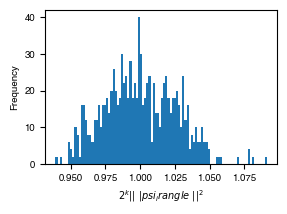

In [12]:
fig, (ax) = plt.subplots(1, 1, figsize=(3, 2))
ax.hist(norms * nslices, bins=100);
ax.set_xlabel(r'$2^k||~|psi_irangle~||^2$')
ax.set_ylabel('Frequency')
# plt.savefig('norms.pdf')

## Compute exact state vector

In [13]:
exact_sv = exact_tree.contract(operands)
exact_sv = exact_sv.reshape(-1)
exact_sv = exact_sv / np.sqrt(np.sum(np.abs(exact_sv)**2))

## Sliced statevector fidelity Supplementary Fig. 13b
### Here, we compute the state vector corresponding to contracting only a fraction $f$ of slices. The state is expected to have fidelity close to $f$.

In [14]:
fs = []
fidelities = []
for f in tqdm(10 ** np.linspace(-1, -3, 21)):
    fs.append(f)
    sv = np.zeros([2] * N, dtype=np.complex128)
    slices = np.random.choice(a=np.arange(nslices), size=int(nslices * f), replace=False)
    for i in slices:
        sv += tree.contract_slice(operands, i)
    sv = sv.reshape(-1)
    sv = sv / np.sqrt(np.sum(np.abs(sv)**2))
    fidelities.append(np.abs(np.dot(sv.conj(), exact_sv)) ** 2)
fs = np.array(fs)
fidelities = np.array(fidelities)

100%|██████████| 21/21 [00:07<00:00,  2.80it/s]


Text(0, 0.5, '$\\phi$')

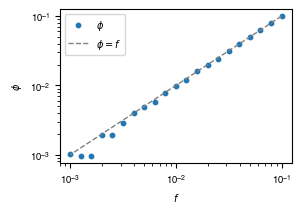

In [15]:
fig, (ax) = plt.subplots(1, 1, figsize=(3, 2))
ax.scatter(fs, fidelities, s=10, label=r'$\phi$')
ax.plot(fs, fs, '--', linewidth=1, color = 'gray', label=r'$\phi=f$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.set_xlabel(r'$f$')
ax.set_ylabel(r'$\phi$')
# plt.savefig('phi_vs_f.svg')

## Top $k$ sampling

### Skip this if you wish to load precomputed results, just run the cell that calls np.load

### Computing the contribution to the state vector due to each slice, this is to reuse them later to avoid recontracting the same slice.

In [16]:
slice_svs = []
for i in tqdm(range(nslices)):
    sv = tree.contract_slice(operands, i)
    sv = sv.reshape(-1)
    slice_svs.append(sv)
slice_svs = np.array(slice_svs).T

100%|██████████| 1024/1024 [00:19<00:00, 53.12it/s]


### The following performs top sampling.

1. Sample $M$ bitstrings
2. Compute the amplitudes of these bitstrings using partial tensor network contraction on a fraction $\phi$ of slices
3. Output the bitstring with the maximum magnitude amplitude

In [14]:
raise ValueError('This cell takes hours to run. 100k samples is necessary to high quality statistics. Reduce the number of samples to get faster results.')

M = 64
'''Increase samples_per_M to 100k to get good statistics'''
samples_per_M = 100000

all_probs = []
all_top_amplitudes = []
all_u_amplitudes = []
ks = [6, 6, 3, 6]
phis = [0.28, 0.1, 0.28, 0.025]
for phi, k in zip(phis, ks):
    M = 2**k
    probs = []
    top_amplitudes = []
    u_amplitudes = []
    for _ in tqdm(range(samples_per_M)):
        slices = np.random.choice(a=np.arange(nslices), size=int(nslices * phi), replace=False) # Choose a random subset of slices, a fraction of $\phi$
        bitstrings = np.random.choice(np.arange(2**N), M, replace=False) # Choosing random bitstrings
        slice_amplitudes = slice_svs[bitstrings] # Choose the amplitudes of all slices corresponding to the M random bitstrings
        amplitudes = slice_amplitudes[:, slices] # Choose the amplitudes of the random fraction of slices
        amplitudes = np.sum(amplitudes, axis=1) # Summing over the chosen slices
        amplitudes /= np.sqrt(phi)
        idx = np.argmax(np.abs(amplitudes)**2) # Choose the top bitstring by amplitude magnitude
        bitstring = bitstrings[idx]
        # Recording the amplitudes
        top_amplitudes.append(amplitudes[idx])
        u_amplitudes.append((exact_sv[bitstring]-np.sqrt(phi)*top_amplitudes[-1])/np.sqrt(1-phi))
        prob = np.abs(exact_sv[bitstring]) ** 2
        probs.append(prob)
    all_probs.append(probs)
    all_top_amplitudes.append(top_amplitudes)
    all_u_amplitudes.append(u_amplitudes)

100%|██████████| 100000/100000 [28:17<00:00, 58.91it/s]


In [15]:
all_probs = np.array(all_probs)
all_top_amplitudes = np.array(all_top_amplitudes)
all_u_amplitudes = np.array(all_u_amplitudes)

In [ ]:
np.save('top_all_probs.npy', all_probs)
np.save('top_all_top_amplitudes.npy', all_top_amplitudes)
np.save('top_all_u_amplitudes.npy', all_u_amplitudes)

In [ ]:
all_probs = np.load('top_all_probs')
all_top_amplitdues = np.load('top_all_top_amplitudes')
all_u_amplitudes = np.load('top_all_u_amplitudes')

## Supplementary Fig. 15a

In [16]:
hist = np.histogram(np.abs(all_top_amplitudes[0]) ** 2 * 2**N, bins=np.linspace(2, 10, 81));

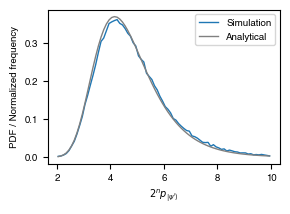

In [17]:
fig, (ax) = plt.subplots(1, 1, figsize=(3, 2))

ps = np.arange(2.05, 10, 0.1)
ax.plot(ps, hist[0] / samples_per_M / 0.1, linewidth=1, label='Simulation')
ax.plot(ps, pdf_top(1, 6, ps), linewidth=1, color='gray', label='Analytical')
ax.set_xlabel(r"$2^n p_{\vert\psi'\rangle}$")
ax.set_ylabel(r'PDF / Normalized frequency')
plt.legend()
# plt.savefig('top_amplitudes.pdf')

## Supplementary Fig. 15b

In [18]:
hist = np.histogram(np.abs(all_u_amplitudes[0]) ** 2 * 2**N, bins=np.linspace(0, 5, 51));

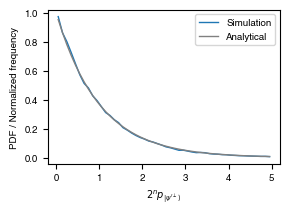

In [19]:
fig, (ax) = plt.subplots(1, 1, figsize=(3, 2))

ps = np.arange(0.05, 5, 0.1)
ax.plot(ps, hist[0] / samples_per_M / 0.1, linewidth=1, label='Simulation')
ax.plot(ps, pdf_u(1, ps), linewidth=1, color='gray', label='Analytical')
ax.set_xlabel(r"$2^n p_{\vert\psi'^{\perp}\rangle}$")
ax.set_ylabel(f'PDF / Normalized frequency')
plt.legend()
# plt.savefig('u_amplitudes.pdf')

## Supplementary Fig. 15c

In [20]:
prod = all_top_amplitudes[0].reshape(-1) * all_u_amplitudes[0].conj().reshape(-1)
hist = np.histogram(np.real(prod / np.abs(prod)), bins=np.linspace(-1, 1, 201));

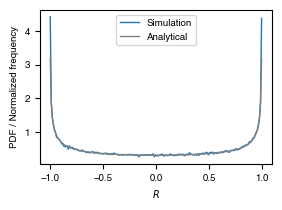

In [21]:
fig, (ax) = plt.subplots(1, 1, figsize=(3, 2))

rs = np.arange(-0.995, 1, 0.01)
ax.plot(rs, hist[0] / samples_per_M / 0.01, linewidth=1, label='Simulation')
ax.plot(rs, f_R(rs), linewidth=1, color='gray', label='Analytical')
ax.set_xlabel(f'$R$')
ax.set_ylabel(f'PDF / Normalized frequency')
plt.legend()
# plt.savefig('R.pdf')

# Monte-Carlo reproduces the distribution of top sampling

### Analytical PDF, numerically integrated result

In [22]:
phi = 0.28
k = 6
n = 1

ps = np.linspace(0, 7,  141)


densities = [

np.array([np.nan, 0.499945, 0.518032, 0.534282, 0.548778, 0.561604, 
0.572839, 0.582564, 0.590854, 0.597784, 0.603428, 0.607857, 0.611138, 
0.613339, 0.614523, 0.614752, 0.614083, 0.612575, 0.610285, 0.607265, 
0.603568, 0.599241, 0.594333, 0.588888, 0.58295, 0.57656, 0.569757, 
0.56258, 0.555065, 0.547245, 0.539154, 0.530822, 0.522278, 0.513549, 
0.504663, 0.495642, 0.486509, 0.477287, 0.467994, 0.458651, 0.449273, 
0.439878, 0.430482, 0.421097, 0.411739, 0.402419, 0.393149, 0.383939, 
0.3748, 0.365741, 0.35677, 0.347895, 0.339122, 0.330458, 0.321909, 
0.31348, 0.305176, 0.297, 0.288956, 0.281048, 0.273277, 0.265647, 
0.258159, 0.250815, 0.243616, 0.236562, 0.229655, 0.222894, 0.21628, 
0.209813, 0.203491, 0.197315, 0.191284, 0.185396, 0.179651, 0.174047, 
0.168583, 0.163257, 0.158067, 0.153013, 0.148091, 0.143301, 0.138639, 
0.134104, 0.129694, 0.125407, 0.12124, 0.117192, 0.113259, 0.10944, 
0.105733, 0.102134, 0.0986423, 0.0952548, 0.0919693, 0.0887835, 
0.0856952, 0.0827019, 0.0798015, 0.0769916, 0.0742701, 0.0716346, 
0.069083, 0.0666132, 0.0642229, 0.0619101, 0.0596727, 0.0575086, 
0.0554158, 0.0533924, 0.0514363, 0.0495458, 0.0477188, 0.0459536, 
0.0442483, 0.0426012, 0.0410106, 0.0394747, 0.037992, 0.0365607, 
0.0351794, 0.0338464, 0.0325604, 0.0313197, 0.030123, 0.0289689, 
0.0278559, 0.0267829, 0.0257485, 0.0247514, 0.0237905, 0.0228644, 
0.0219722, 0.0211126, 0.0202845, 0.019487, 0.0187189, 0.0179793, 
0.0172672, 0.0165816, 0.0159217]),

np.array([np.nan, 1.23683, 1.20187, 1.16751, 1.13377, 1.10066, 1.06819, 
1.03638, 1.00524, 0.974758, 0.944952, 0.915821, 0.887365, 0.859585, 
0.832477, 0.806038, 0.780264, 0.755151, 0.73069, 0.706876, 0.6837, 
0.661155, 0.639231, 0.617919, 0.597209, 0.57709, 0.557553, 0.538585, 
0.520177, 0.502317, 0.484994, 0.468195, 0.451911, 0.436128, 0.420835, 
0.406021, 0.391674, 0.377783, 0.364336, 0.351322, 0.338729, 0.326547, 
0.314765, 0.30337, 0.292354, 0.281705, 0.271413, 0.261468, 0.25186, 
0.242578, 0.233614, 0.224958, 0.2166, 0.208532, 0.200744, 0.193229, 
0.185977, 0.178979, 0.172227, 0.165713, 0.15943, 0.15337, 0.147526, 
0.14189, 0.136455, 0.131216, 0.126165, 0.121296, 0.116603, 0.112081, 
0.107724, 0.103527, 0.0994845, 0.0955921, 0.0918451, 0.0882388, 
0.0847687, 0.08143, 0.0782185, 0.0751295, 0.0721585, 0.0693013, 
0.0665535, 0.0639111, 0.06137, 0.0589265, 0.056577, 0.0543179, 
0.0521459, 0.0500578, 0.0480505, 0.0461208, 0.044266, 0.0424833, 
0.04077, 0.0391234, 0.0375412, 0.0360208, 0.0345599, 0.0331564, 
0.031808, 0.0305127, 0.0292684, 0.0280732, 0.0269253, 0.0258228, 
0.024764, 0.0237472, 0.0227709, 0.0218335, 0.0209334, 0.0200693, 
0.0192397, 0.0184434, 0.0176789, 0.0169452, 0.0162409, 0.015565, 
0.0149163, 0.0142938, 0.0136964, 0.0131232, 0.0125732, 0.0120455, 
0.0115392, 0.0110535, 0.0105875, 0.0101405, 0.00971177, 0.0093005, 
0.00890603, 0.00852769, 0.00816484, 0.00781685, 0.00748314, 
0.00716312, 0.00685626, 0.00656201, 0.00627987, 0.00600936, 0.00575]),

np.array([np.nan, 1.05266, 1.0414, 1.0289, 1.0153, 1.00071, 0.985263, 
0.969061, 0.952207, 0.934794, 0.916909, 0.89863, 0.880033, 0.861185, 
0.84215, 0.822983, 0.803738, 0.784464, 0.765205, 0.746, 0.726887, 
0.707898, 0.689063, 0.670411, 0.651964, 0.633744, 0.615771, 0.598062, 
0.580631, 0.563491, 0.546655, 0.53013, 0.513926, 0.498049, 0.482505, 
0.467297, 0.452429, 0.437902, 0.423719, 0.409879, 0.396382, 0.383226, 
0.370411, 0.357934, 0.345792, 0.333981, 0.322498, 0.311339, 0.300499, 
0.289974, 0.279759, 0.269847, 0.260235, 0.250916, 0.241884, 0.233134, 
0.22466, 0.216454, 0.208512, 0.200827, 0.193393, 0.186203, 0.179252, 
0.172533, 0.16604, 0.159767, 0.153709, 0.147858, 0.142209, 0.136757, 
0.131495, 0.126418, 0.121521, 0.116798, 0.112244, 0.107854, 0.103622, 
0.0995441, 0.0956147, 0.0918292, 0.0881831, 0.0846718, 0.0812908, 
0.078036, 0.074903, 0.0718878, 0.0689864, 0.0661949, 0.0635096, 
0.0609267, 0.0584428, 0.0560544, 0.0537582, 0.0515508, 0.0494291, 
0.04739, 0.0454307, 0.0435481, 0.0417396, 0.0400024, 0.0383339, 
0.0367315, 0.0351929, 0.0337157, 0.0322975, 0.0309362, 0.0296296, 
0.0283757, 0.0271724, 0.0260178, 0.0249101, 0.0238475, 0.0228282, 
0.0218506, 0.020913, 0.0200139, 0.0191518, 0.0183253, 0.0175329, 
0.0167733, 0.0160452, 0.0153474, 0.0146786, 0.0140377, 0.0134236, 
0.0128352, 0.0122715, 0.0117315, 0.0112141, 0.0107186, 0.010244, 
0.0097895, 0.0093542, 0.00893736, 0.00853821, 0.00815602, 0.0077901, 
0.00743977, 0.00710437, 0.0067833, 0.00647594]),

np.array([np.nan, 1.64618, 1.57318, 1.50339, 1.43667, 1.37289, 1.31192, 1.25364,
1.19792, 1.14467, 1.09376, 1.04511, 0.9986, 0.954147, 0.911659,
0.871049, 0.832237, 0.795141, 0.759688, 0.725805, 0.693423, 0.662476,
0.632901, 0.604638, 0.577629, 0.551818, 0.527154, 0.503585, 0.481063,
0.459542, 0.438977, 0.419328, 0.400552, 0.382612, 0.365471, 0.349093,
0.333444, 0.318493, 0.304209, 0.290561, 0.277522, 0.265065, 0.253164,
0.241794, 0.230932, 0.220555, 0.210642, 0.201172, 0.192125, 0.183483,
0.175228, 0.167342, 0.159809, 0.152614, 0.14574, 0.139175, 0.132904,
0.126914, 0.121193, 0.115728, 0.110508, 0.105523, 0.100761,
0.0962136, 0.0918701, 0.0877217, 0.0837597, 0.0799758, 0.0763621,
0.0729108, 0.0696148, 0.0664671, 0.0634611, 0.0605904, 0.057849,
0.055231, 0.052731, 0.0503436, 0.0480638, 0.0458868, 0.043808,
0.0418229, 0.0399274, 0.0381175, 0.0363892, 0.0347389, 0.0331632,
0.0316587, 0.0302221, 0.0288504, 0.0275407, 0.0262903, 0.0250963,
0.0239564, 0.0228681, 0.021829, 0.0208369, 0.0198883, 0.0189796,
0.0181091, 0.0172745, 0.0164735, 0.0157041, 0.0149643, 0.0142529,
0.0135692, 0.0129131, 0.0122851, 0.0116859, 0.0111159, 0.010575,
0.0100622, 0.00957587, 0.00911428, 0.00867571, 0.00825863,
0.00786173, 0.00748388, 0.00712405, 0.00678128, 0.00645471,
0.00614352, 0.00584695, 0.00556427, 0.0052948, 0.0050379, 0.00479296,
0.00455941, 0.0043367, 0.00412432, 0.00392176, 0.00372856,
0.00354428, 0.00336849, 0.00320079, 0.0030408, 0.00288814,
0.00274248, 0.00260348, 0.00247082, 0.0023442])

]

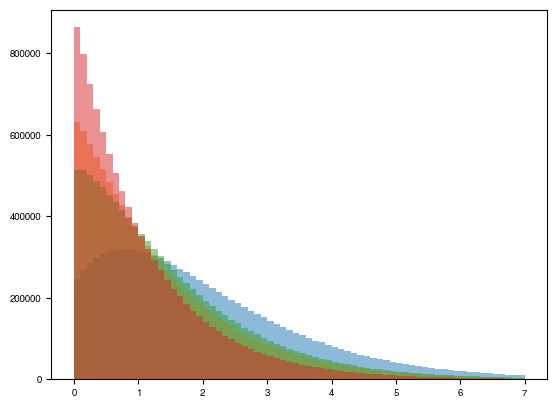

In [23]:
### Monte-Carlo samples the probabilities
nsamples = 10000000


x = np.linspace(0, 10, 10001)
r = np.linspace(-0.9999, 0.9999, 19999)
PDF_U = pdf_u(2**1, x / 2**1) * (x[1] - x[0]) / 2**1
PDF_U = PDF_U / np.sum(PDF_U)
PDF_R = f_R(r) * (r[1] - r[0])
PDF_R = PDF_R / np.sum(PDF_R)
u_samples = np.random.choice(x, size=nsamples, p=PDF_U)
r_samples = np.random.choice(r, size=nsamples, p=PDF_R)


hists = []
means = []

for k, phi in zip(ks, phis):
    PDF_TOP = pdf_top(2**1, k, x / 2**1) * (x[1] - x[0]) / 2**1
    PDF_TOP = PDF_TOP / np.sum(PDF_TOP)
    top_samples = np.random.choice(x, size=nsamples, p=PDF_TOP)
    result = phi * top_samples + (1 - phi) * u_samples + 2 * np.sqrt(phi * (1 - phi)) * r_samples * np.sqrt(top_samples * u_samples)
    means.append(np.mean(result)-1)
    hists.append(plt.hist(result, bins=np.linspace(0,7,71), alpha=0.5));

### Supplementary Fig. 14

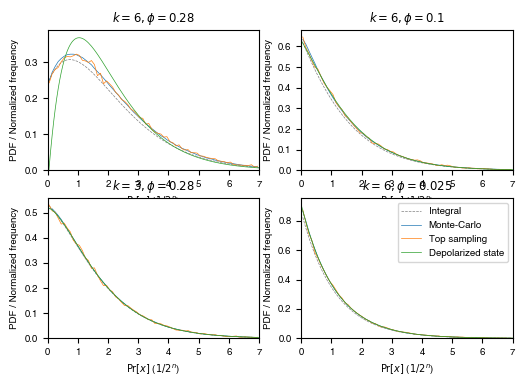

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(6, 4))

Phis = ['028', '01', '028', '0025']
bin_centers = np.linspace(0.05, 6.95, 70)

for i, (k, phi) in enumerate(zip(ks, phis)):
    probs = all_probs[i]
    actual_hist = np.histogram(probs, bins=np.linspace(0, 7, 71)/2**20)
    actual_freq = actual_hist[0] / (np.sum(actual_hist[0]) * (bin_centers[1] - bin_centers[0]))
    rescaled_freq = hists[i][0] / (np.sum(hists[i][0]) * (bin_centers[1] - bin_centers[0]))
    rescaled_density = densities[i] / 2
    honest_density = means[i] * pdf_q(1, ps) + (1 - means[i]) * pdf_u(1, ps)

    axs[i//2][i%2].plot(ps, rescaled_density, '--', linewidth=0.5, color='gray', label='Integral')
    axs[i//2][i%2].plot(bin_centers, rescaled_freq, linewidth=0.5, label='Monte-Carlo')
    axs[i//2][i%2].plot(bin_centers, actual_freq, linewidth=0.5, label='Top sampling')
    axs[i//2][i%2].plot(ps, honest_density, linewidth=0.5, label='Depolarized state')
    axs[i//2][i%2].set_title(f'$k={k}, \phi={phi}$')
    axs[i//2][i%2].set_xlabel(f'$\Pr[x]$ ($1/2^n$)')
    axs[i//2][i%2].set_ylabel(f'PDF / Normalized frequency')
    axs[i//2][i%2].set_xlim(0, 7)
    axs[i//2][i%2].set_ylim(0, )
plt.legend()